In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import f1_score, classification_report
from modeling import optimize, train, evaluate, preprocess, plot_score_comparison
from itertools import product
import seaborn as sns
np.random.seed(42)

In [2]:
df = pd.read_csv('data/processed/clean_and_filled.csv')
types = pd.read_csv('data/processed/feature_types.csv').dropna()

for group in types.groupby('feature_type').groups:
    print(types.groupby('feature_type').get_group(group))
    print()

           feature feature_type
3  cp_type_no_pain            ?

               feature feature_type
33  blood_press_s_rest           CT
48     heart_rate_peak           CT
49     heart_rate_rest           CT
53           ex_angina           CT

                feature feature_type
34                 chol            E
35               smoker            E
36  smoker_cigs_per_day            E
37         smoker_years            E
38  fasting_blood_sugar            E

                 feature feature_type
0                  sex_F            G
1                  sex_M            G
29                   age            G
39  heart_disease_family            G

                   feature feature_type
2  cp_type_atypical_angina            H
4      cp_type_non_anginal            H
5   cp_type_typical_angina            H

                               feature feature_type
6                 rest_ecg_hypertrophy            T
7                      rest_ecg_normal            T
8               rest_ec

In [3]:
model_constructor = RandomForestClassifier

# Question 3
Is there a simple or low-cost way to evaluate one's own risk of heart attack?

Training models...: 100%|██████████| 120/120 [00:19<00:00,  6.14it/s]


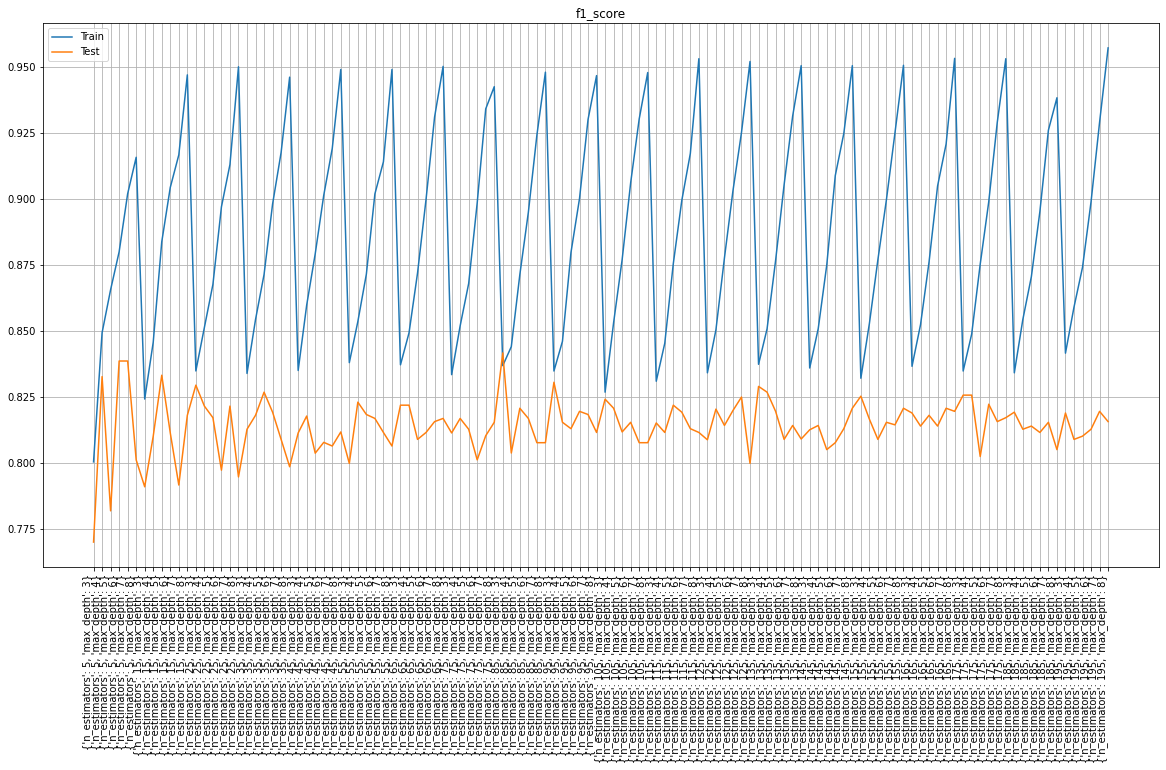

In [4]:
cheap_cols = list(types[types.feature_type.isin(['CT', 'H', 'G', 'E'])].feature)
cheap_params = [{'n_estimators': n, 'max_depth': d} for n, d in product(np.arange(5, 201, 10), np.arange(3, 9))]
cheap_model, cheap_training, cheap_score, cheap_param = optimize(df[cheap_cols + ['target']], 0.3, model_constructor, cheap_params, plot=True)

## Comparing to our baseline model
The baseline was trained with all the features

In [7]:
from joblib import load
full_model = load('data/results/gb_full-features_model.joblib')
X_train, X_test, y_train, y_test = preprocess(df)
_, full_score = evaluate(full_model, X_train, X_test, y_train, y_test)
full_score

{'f1_score': 0.8646864686468646,
 'accuracy_score': 0.8481481481481481,
 'precision_score': 0.8397435897435898,
 'recall_score': 0.891156462585034}

                      full   low_cost
f1_score         86.468647  84.177215
accuracy_score   84.814815  81.481481
precision_score  83.974359  78.698225
recall_score     89.115646  90.476190


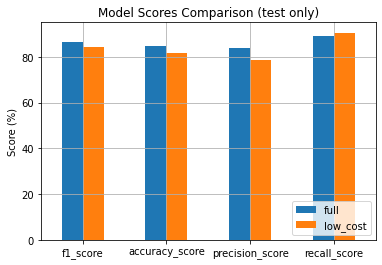

In [8]:
plot_score_comparison([full_score, cheap_score], ['full', 'low_cost'], save_path='data/results/full_vs_low_cost_model_scores.png')

## Bonus! Let's test against the framingham score
*Disclaimer:* Not all the required data for the Framingham score is present in this dataset. As such, the Framingham model will tend to underestimate heart risk in this sample. We're also assuming no blood pressure treatment, as there is no such info on the dataset.

d:\Code\udacity\ds_capstone_1-Blog_post\heart_attack_analysis\.venv\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
Error at threshold 30.0: Classification metrics can't handle a mix of binary and unknown targets
{'f1_score': 0.735632183908046, 'accuracy_score': 0.6592592592592592, 'precision_score': 0.6368159203980099, 'recall_score': 0.8707482993197279}
8.056112224448897


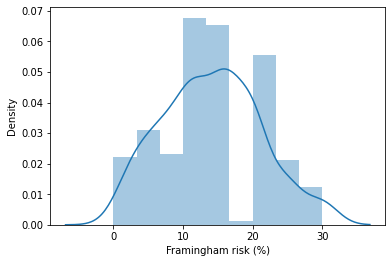

In [9]:
from framingham import FraminghamModel
from sklearn.metrics import confusion_matrix, classification_report, r2_score, f1_score, accuracy_score, precision_score, recall_score

def find_framingham_split(data_path='data/processed/clean_and_filled.csv', metrics=[f1_score, accuracy_score, precision_score, recall_score]):
    "Iteratively search for an optimal threshold for binarization of Framingham results"
    fm = FraminghamModel()

    # Read and preprocess data
    fr_df = pd.read_csv(data_path)
    fr_df.smoker = fr_df.smoker.replace({1: 'yes', 0: 'no'})
    fr_df.sex_M = fr_df.sex_M.replace({1: 'M', 0: 'F'})

    fr_X_test = fr_df.loc[X_test.index].copy()

    # Run prediction
    fr_results = fr_X_test.apply(fm.predict, axis=1) * 100

    # Plot result distribution
    sns.distplot(fr_results)
    plt.xlabel('Framingham risk (%)')
    plt.savefig('data/results/fram_hist.png')
    best_thresh = 0
    best_score = 0
    best_preds = None
    
    # Search for optimal binarization threshold
    for threshold in np.linspace(fr_results.min(), fr_results.max(), 500):
        fr_preds = (fr_results > threshold).replace({True: 1, False: 0})
        try:
            score = f1_score(y_test, fr_preds)
        except Exception as e:
            print(f'Error at threshold {threshold}: {e}')
        if score > best_score:
            best_thresh = threshold
            best_score = score
            best_preds = fr_preds

    # Compute all metrics of interest
    fr_score = {}

    for metric in metrics:
        fr_score[metric.__name__] = metric(y_test, best_preds)

    return fr_score, best_thresh

fr_score, best_thresh = find_framingham_split()
print(fr_score)
print(best_thresh)

                 framingham   low_cost
f1_score          73.563218  84.177215
accuracy_score    65.925926  81.481481
precision_score   63.681592  78.698225
recall_score      87.074830  90.476190


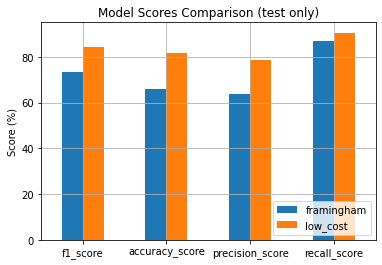

In [10]:
plot_score_comparison([fr_score, cheap_score], ['framingham', 'low_cost'], save_path='data/results/fram_vs_low_cost_model_scores.png')